# Import the necessary packages



In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import warnings
warnings.filterwarnings('ignore')

#Download data sample

In [2]:
!wget -q https://github.com/csabiu/ML_tutorial/raw/refs/heads/master/class.tar.gz.parta{a,b,c,d,e,f,g,h,i} > tmp
!cat class.tar.gz.parta* > class.tar.gz
!gunzip class.tar.gz
!tar -xvf class.tar > tmp
!rm class.tar*
!rm tmp
!ls

class  sample_data


In [3]:
# aletrnative
#!wget https://archive.kasi.re.kr/bigdata/temp/class.tar.gz
#!tar zxf class.tar.gz
#!rm class.tar.gz
#!ls

## Lets look at an image



(424, 424, 3)


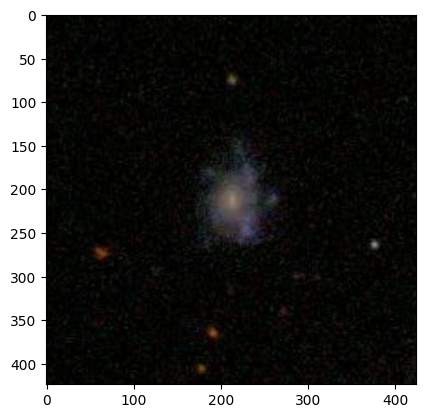

In [4]:
jpgfile = Image. open("class/100134.jpg")
plt.imshow(jpgfile)
print(np.shape(jpgfile))


# Lets crop it and de-center

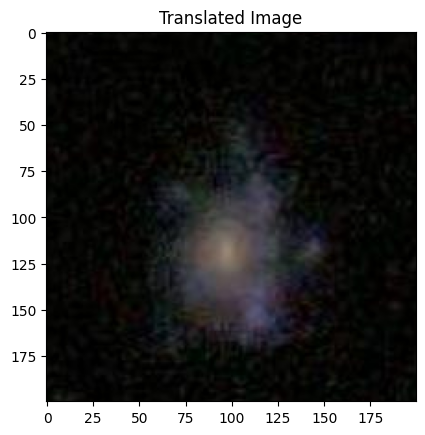

(424, 424, 3)


In [5]:
# Define the random ranslation shift
x_shift = np.random.randint(-20,20)
y_shift = np.random.randint(-20,20)

# Perform the translation shift using image.transform()
translated_image = jpgfile.transform(jpgfile.size, Image.AFFINE, (1, 0, x_shift, 0, 1, y_shift))
cropped_image = translated_image.crop((112,112,312,312))

# Display the translated image
plt.figure()
plt.imshow(cropped_image)
plt.title('Translated Image')
plt.show()

# Print shape of translated image
print(np.shape(translated_image))


# And lower the resolution

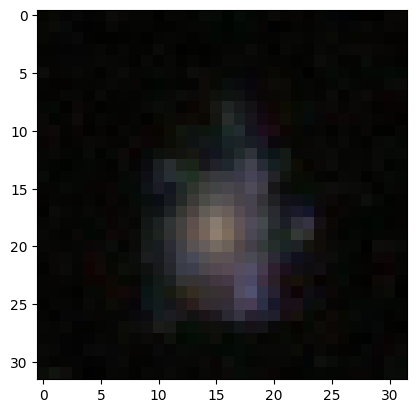

In [6]:
target_size = 32
lowres_image = cropped_image.resize((target_size,target_size),Image.Resampling.LANCZOS)
plt.imshow(lowres_image)

# Split into RGB colors

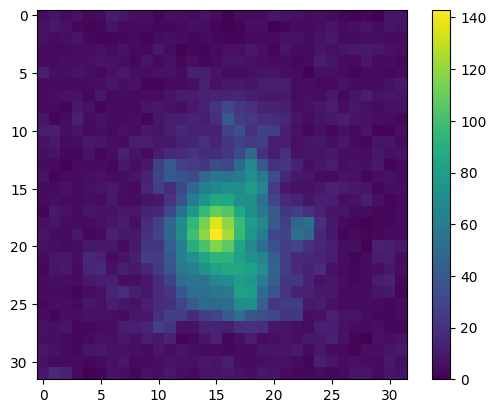

In [7]:
r,g,b=lowres_image.split()
plt.imshow(r)
plt.colorbar()

# Normalise the pixel values to (0,1)

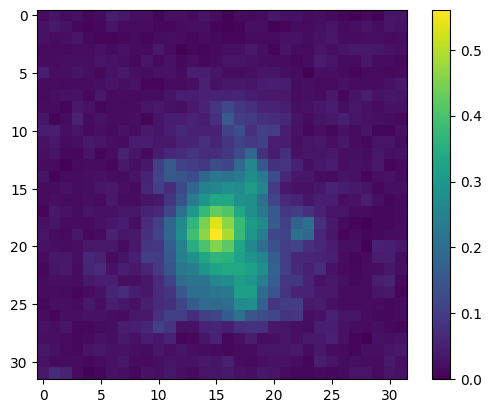

In [8]:
im=np.zeros((target_size,target_size))
im[:,:]=r
im=im/255.
plt.imshow(im)
plt.colorbar()

# Load the labels (truth) data

(Image ID, galaxy type) - 0=smooth, 1=featured

In [9]:
data=np.loadtxt("class/truth.txt",dtype='i')
print(np.shape(data))
labels=data[:,1]

print(data[:10,:]) # print first 10 entries

(16885, 2)
[[100090      0]
 [100134      1]
 [100322      1]
 [100380      1]
 [100458      0]
 [100479      0]
 [100520      1]
 [100672      0]
 [100673      1]
 [100724      0]]


# Lets transform all the images and save into an array

In [10]:
images=[]

for i in (data[:,0]):
  x_shift = np.random.randint(-20,20)
  y_shift = np.random.randint(-20,20)
  filename=str(int(i))+".jpg"
  jpgfile = Image. open("./class/"+filename)
  translated_image = jpgfile.transform(jpgfile.size, Image.AFFINE, (1, 0, x_shift, 0, 1, y_shift))
  cropped_image = translated_image.crop((112,112,312,312))
  lowres_image = cropped_image.resize((target_size,target_size),Image.Resampling.LANCZOS)
  images.append(np.array(lowres_image))

images=np.asarray(images)
images=images/255.

# remove color - make each chanel the same by averaging
images[:,:,:,0]=np.mean(images,axis=3)
images[:,:,:,1]=images[:,:,:,0]
images[:,:,:,2]=images[:,:,:,0]
print(np.shape(images))

(16885, 32, 32, 3)


# Split images and labels into training and test data

In [11]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.4, random_state=42)

print(np.shape(train_data))
print(np.shape(train_label))
print(np.shape(test_data))
print(np.shape(test_label))

(10131, 32, 32, 3)
(10131,)
(6754, 32, 32, 3)
(6754,)


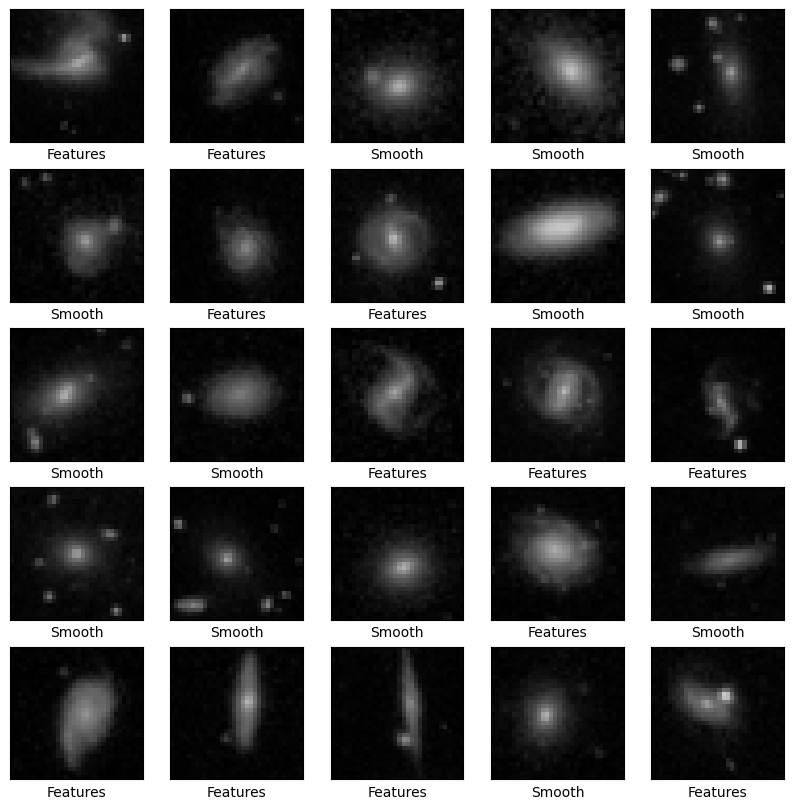

In [12]:
class_names = ['Smooth', 'Features']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_data[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[int(train_label[i])])
plt.show()

# Define a simple neural network

In [13]:
model = keras.Sequential([
    keras.layers.Input(shape=(target_size, target_size, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)])
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,802 (768.76 KB)

 Trainable params: 196,802 (768.76 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True, min_delta=0.0001)

# reduce lr on plateau callback
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_delta=0.0001)

In [15]:
hist = model.fit(train_data, train_label, epochs=100, validation_split=0.2, callbacks=[es, rlr])

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6256 - loss: 0.6567 - val_accuracy: 0.6556 - val_loss: 0.6224 - learning_rate: 0.0010
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7005 - loss: 0.5817 - val_accuracy: 0.7277 - val_loss: 0.5656 - learning_rate: 0.0010
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7459 - loss: 0.5414 - val_accuracy: 0.7657 - val_loss: 0.5259 - learning_rate: 0.0010
Epoch 4/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7762 - loss: 0.4999 - val_accuracy: 0.7750 - val_loss: 0.5072 - learning_rate: 0.0010
Epoch 5/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7886 - loss: 0.4901 - val_accuracy: 0.7765 - val_loss: 0.4971 - learning_rate: 0.0010
Epoch 6/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7920 - loss: 0.4744 - val_accuracy: 0.7810 - val_loss: 0.5039 - learning_rate: 0.0010
Epoch 7/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8047 - loss: 0.

In [16]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('Test accuracy:', test_acc)

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8006 - loss: 0.4567
Test accuracy: 0.8015990257263184


Set up some of plotting functions

Text(0.5, 0, 'Epoch')

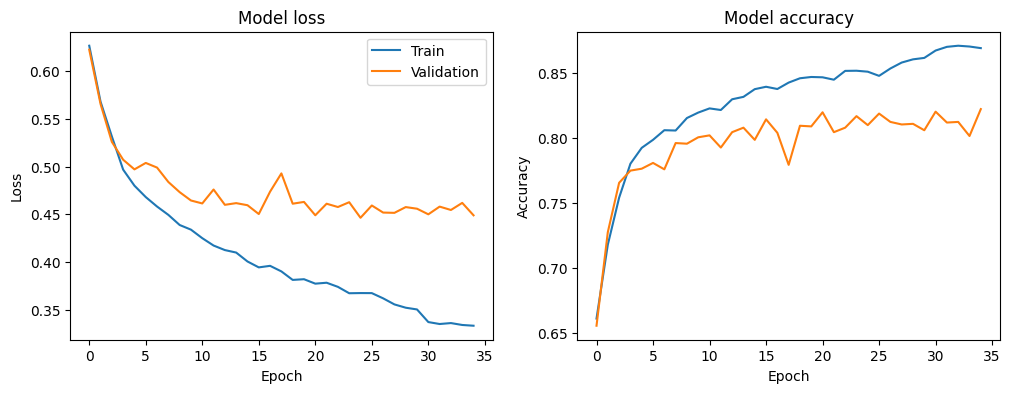

In [17]:
# plot training loss and accuracy history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [18]:
# plotting functions
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[int(true_label)]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([0,1])
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# Make predictions on test data from the trained model

In [19]:
predictions = (model.predict(test_data[:,:,:]))

print("First 10 galaxies")
print("Predicted:",np.argmax(predictions[1:11],axis=1))
print("Truth:    ",np.int_(test_label[1:11]))

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
First 10 galaxies
Predicted: [0 0 0 0 1 0 0 1 0 1]
Truth:     [0 0 0 0 0 0 1 1 0 1]


# Lets visialise these classifications

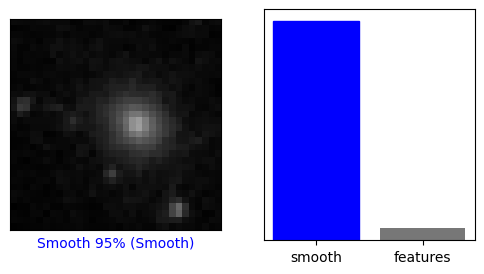

In [20]:
i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, np.int_(test_label), test_data)
f=plt.subplot(1,2,2)
plot_value_array(i, predictions,  np.int_(test_label))
f.axes.set_xticklabels(["smooth","features"])
plt.show()

 Plot the first X test images, their predicted label, and the true label
 Color correct predictions in blue, incorrect predictions in red

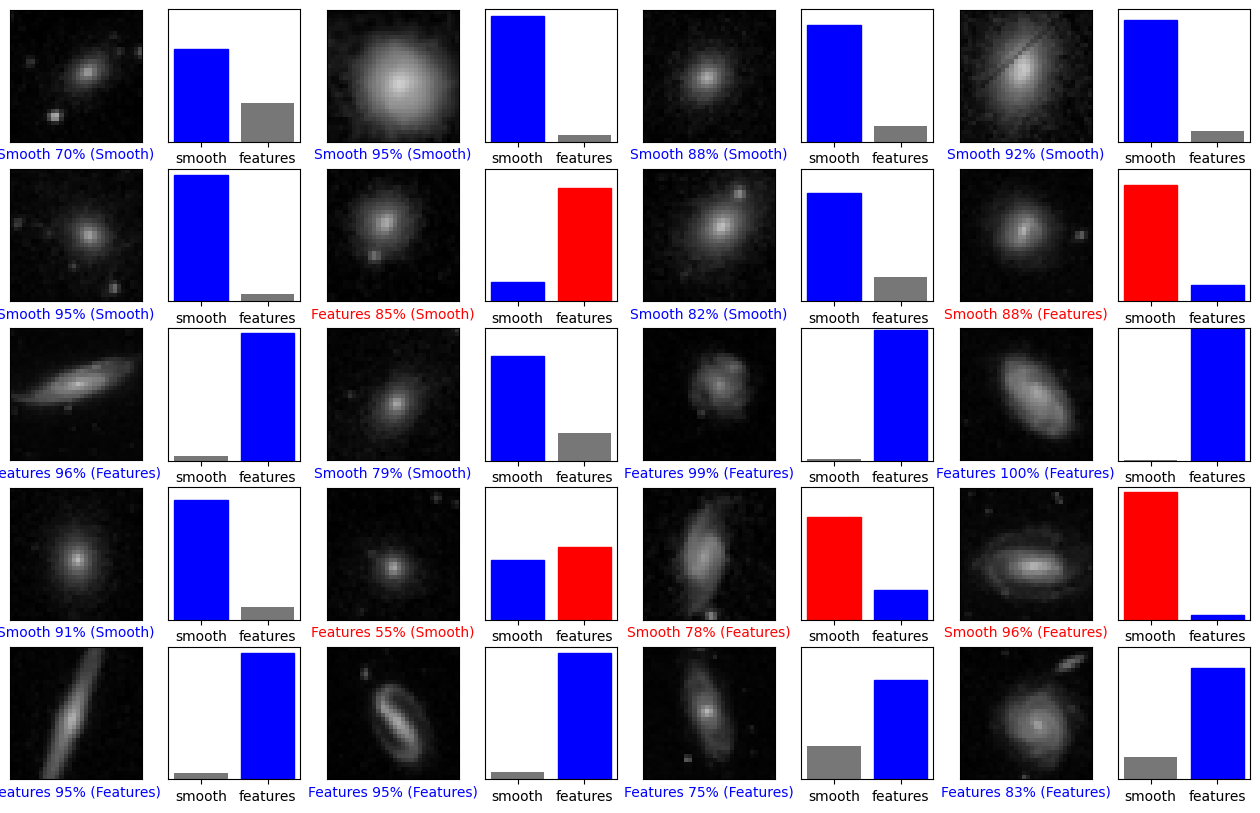

In [21]:
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()


# Define a new convolutional neural network model

In [35]:
def create_cnn_model():
  keras.backend.clear_session()
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(target_size, target_size,3)))
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
  model.add(keras.layers.MaxPooling2D((2, 2))) # pooling
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.25))  # help overfitting
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(2, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = create_cnn_model()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,378 (2.00 MB)

 Trainable params: 525,378 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model on the training data

In [36]:
hist = model.fit(train_data, train_label, epochs=100, validation_split=0.2, callbacks=[es, rlr])

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6842 - loss: 0.5864 - val_accuracy: 0.8407 - val_loss: 0.3642 - learning_rate: 0.0010
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8552 - loss: 0.3386 - val_accuracy: 0.8707 - val_loss: 0.3193 - learning_rate: 0.0010
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8858 - loss: 0.2837 - val_accuracy: 0.8915 - val_loss: 0.2674 - learning_rate: 0.0010
Epoch 4/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8868 - loss: 0.2709 - val_accuracy: 0.8989 - val_loss: 0.2594 - learning_rate: 0.0010
Epoch 5/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9040 - loss: 0.2398 - val_accuracy: 0.9102 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 6/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9201 - loss: 0.2111 - val_accuracy: 0.9117 - val_loss: 0.2295 - learning_rate: 0.0010
Epoch 7/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9263 - loss: 0

# Now make prediction and visualise
# Compare to previous plot

Text(0.5, 0, 'Epoch')

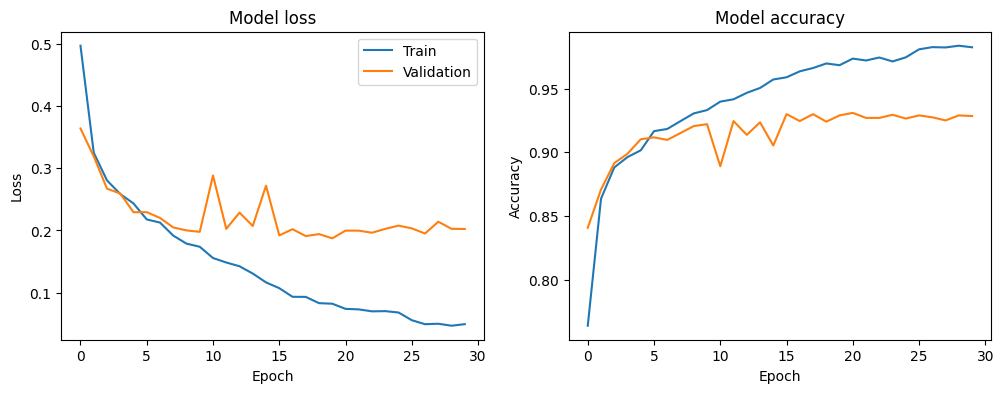

In [37]:
# plot training history again
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


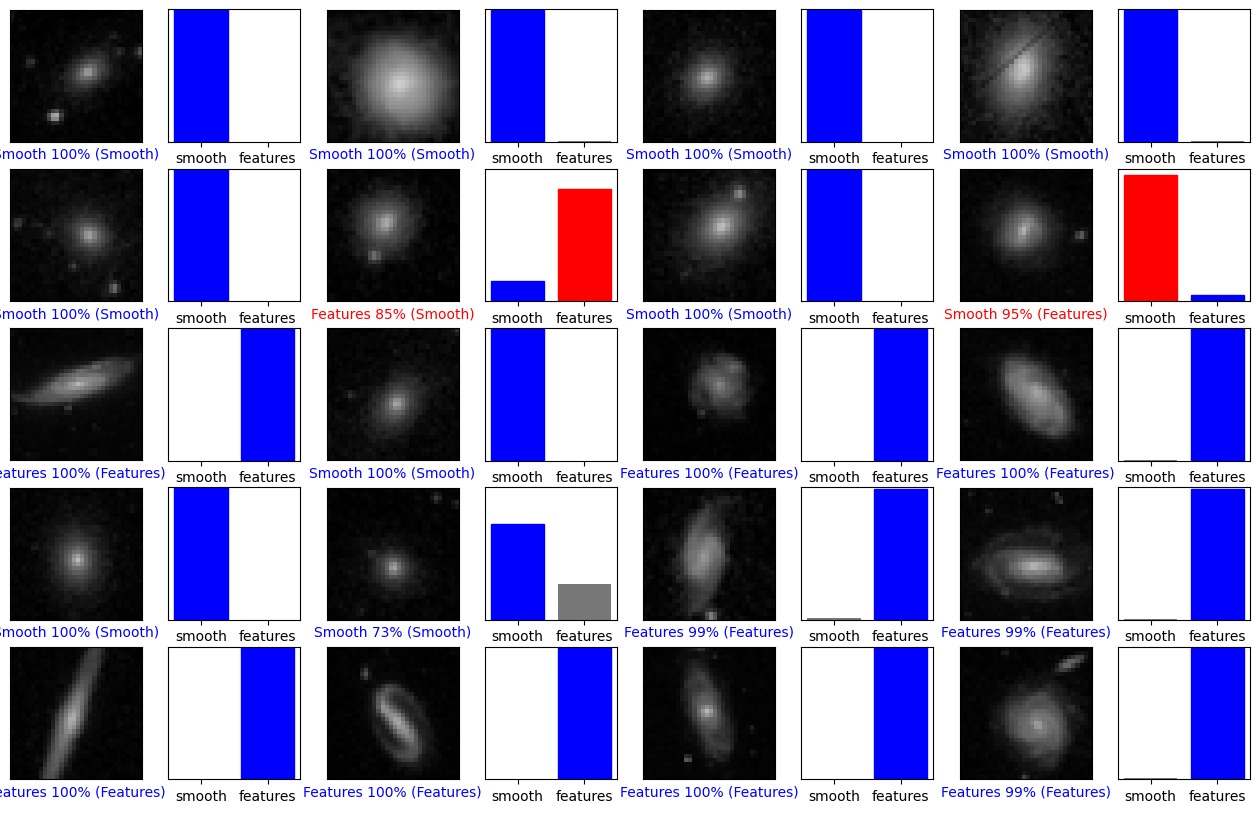

In [38]:
predictions = model.predict(test_data)

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

In [39]:
# compute evaluation metrics: precision and recall
from sklearn.metrics import precision_score, recall_score
print("Precision:",precision_score(np.int_(test_label),np.argmax(predictions,axis=1)))
print("Recall:",recall_score(np.int_(test_label),np.argmax(predictions,axis=1)))


Precision: 0.9285912753542651
Recall: 0.9507823613086771


# Assignment 1:
*   Create you own CNN with different number of layers.
*   Can you improve the precision and recall values?


In [ ]:
results = []

In [58]:
 np.arange(20, 70,1)

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69])

In [51]:
nconv=  np.arange(20, 71,1)
dim = [(2,2),(3,3),(4,4)]
strides= [(1,1),(2,2)]
maxpooling2d = [(2,2),(3,3)]
def create_cnn_model():
  keras.backend.clear_session()
  model = keras.Sequential()
  model.add(keras.layers.Input(shape=(target_size, target_size,3)))
  model.add(keras.layers.Conv2D(nconv, dim, activation='relu',padding='same',strides  = strides))
  model.add(keras.layers.MaxPooling2D(maxpooling2d)) # pooling
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.25))  # help overfitting
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(2, activation='softmax'))

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

model = create_cnn_model()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,378 (2.00 MB)

 Trainable params: 525,378 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
hist = model.fit(train_data, train_label, epochs=100, validation_split=0.2, callbacks=[es, rlr])

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6938 - loss: 0.5837 - val_accuracy: 0.8397 - val_loss: 0.3759 - learning_rate: 0.0010
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8532 - loss: 0.3486 - val_accuracy: 0.8505 - val_loss: 0.3320 - learning_rate: 0.0010
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8775 - loss: 0.2937 - val_accuracy: 0.8860 - val_loss: 0.2788 - learning_rate: 0.0010
Epoch 4/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8945 - loss: 0.2587 - val_accuracy: 0.8624 - val_loss: 0.3164 - learning_rate: 0.0010
Epoch 5/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9024 - loss: 0.2453 - val_accuracy: 0.8851 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 6/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9136 - loss: 0.2240 - val_accuracy: 0.9097 - val_loss: 0.2342 - learning_rate: 0.0010
Epoch 7/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9215 - loss: 0

Text(0.5, 0, 'Epoch')

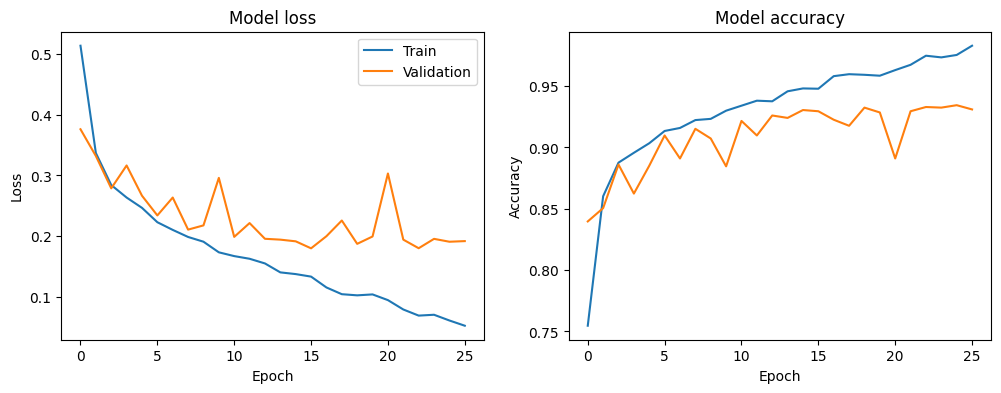

In [53]:
# plot training history again
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')


212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


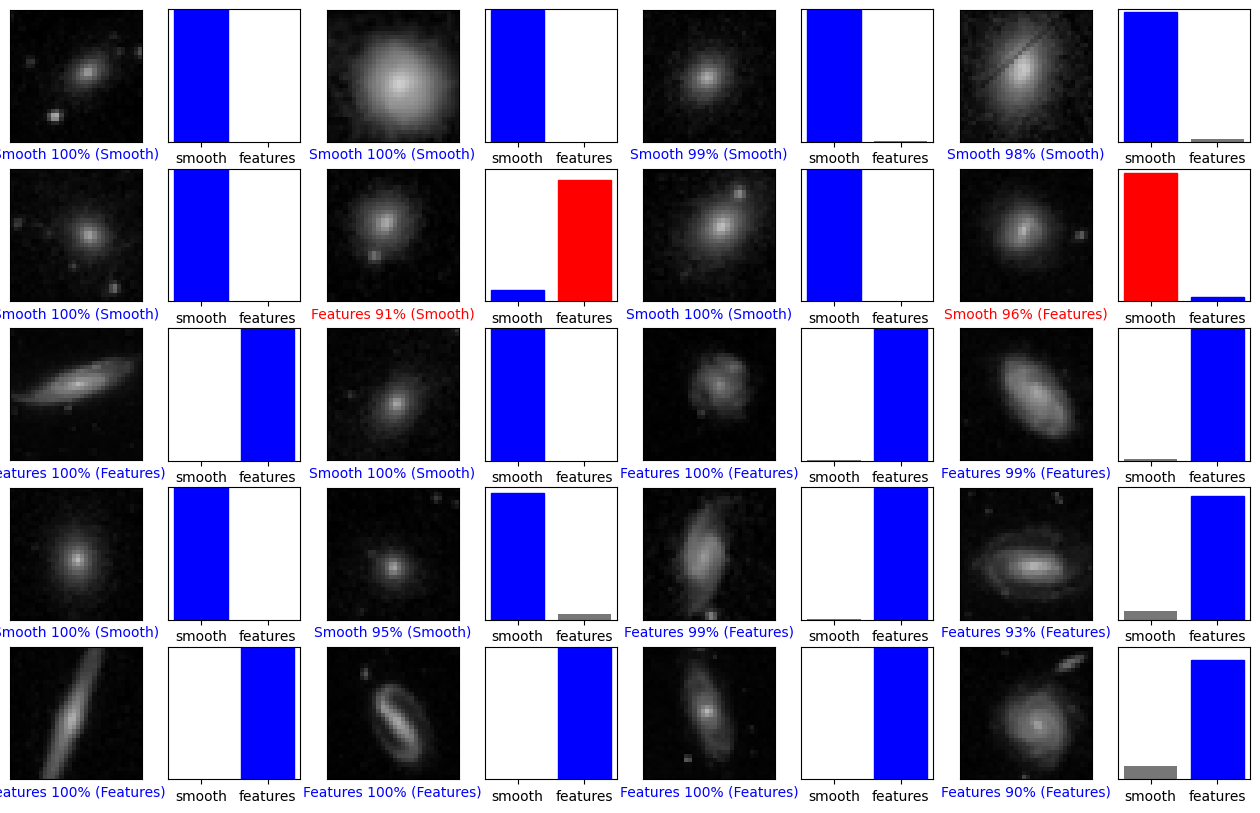

In [54]:
predictions = model.predict(test_data)

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

In [56]:
# compute evaluation metrics: precision and recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(np.int_(test_label),np.argmax(predictions,axis=1))
recall = recall_score(np.int_(test_label),np.argmax(predictions,axis=1))
results.append([nconv, dim, strides, maxpooling2d, precision, recall])
print("Precision:",precision)
print("Recall:",recall)

Precision: 0.9272626318711826
Recall: 0.9502133712660028


In [57]:
results

[[20, (3, 3), (1, 1), (2, 2), 0.9311203319502075, 0.9576102418207681],
 [32, (3, 3), (1, 1), (2, 2), 0.9272626318711826, 0.9502133712660028],
 [32, (3, 3), (1, 1), (2, 2), 0.9272626318711826, 0.9502133712660028]]

# Now add some data augmentations

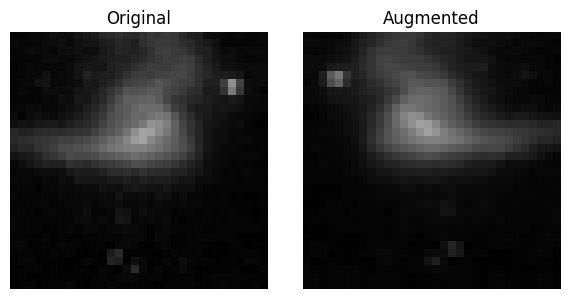

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras.preprocessing.image

# add data augmentation using a generator
datagen = ImageDataGenerator(width_shift_range=.1,
                             height_shift_range=.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')

datagen.fit(train_data[:-100])


# -------------------------------------------------
# visualise

idx = 0
original = train_data[idx]            # shape (H, W, C), dtype float32 or uint8

iterator = datagen.flow(
    original[np.newaxis, ...],        # add batch dimension
    batch_size=1,
    shuffle=False)
augmented = next(iterator)[0]         # take the first (and only) image

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow((original))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow((augmented))
axes[1].set_title("Augmented")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [60]:
# create fresh model
model = create_cnn_model()

# fit model with data augmentation!
hist = model.fit(datagen.flow(train_data[:-100], train_label[:-100],
                    batch_size=64),
                    epochs=100,
                    validation_data=(test_data[-100:], test_label[-100:]),
                    callbacks=[es, rlr]
                    )

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.6811 - loss: 0.5910 - val_accuracy: 0.8500 - val_loss: 0.4328 - learning_rate: 0.0010
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8379 - loss: 0.3776 - val_accuracy: 0.8500 - val_loss: 0.4288 - learning_rate: 0.0010
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8592 - loss: 0.3330 - val_accuracy: 0.8800 - val_loss: 0.3528 - learning_rate: 0.0010
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8687 - loss: 0.3031 - val_accuracy: 0.8800 - val_loss: 0.3101 - learning_rate: 0.0010
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8921 - loss: 0.2782 - val_accuracy: 0.9100 - val_loss: 0.2908 - learning_rate: 0.0010
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8886 - loss: 0.2771 - val_accuracy: 0.9000 - val_loss: 0.2847 - learning_rate: 0.0010
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8866 - 

# Test the trained model on the test data

In [61]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('Test accuracy:', test_acc)

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9464 - loss: 0.1522
Test accuracy: 0.9450696110725403


Text(0.5, 0, 'Epoch')

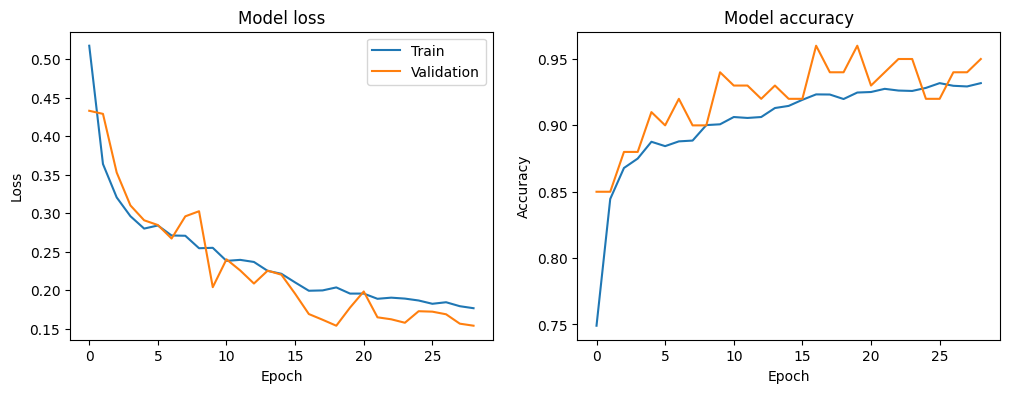

In [62]:
# plot training history again
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Now make prediction and visualise
# Compare to previous plot

212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


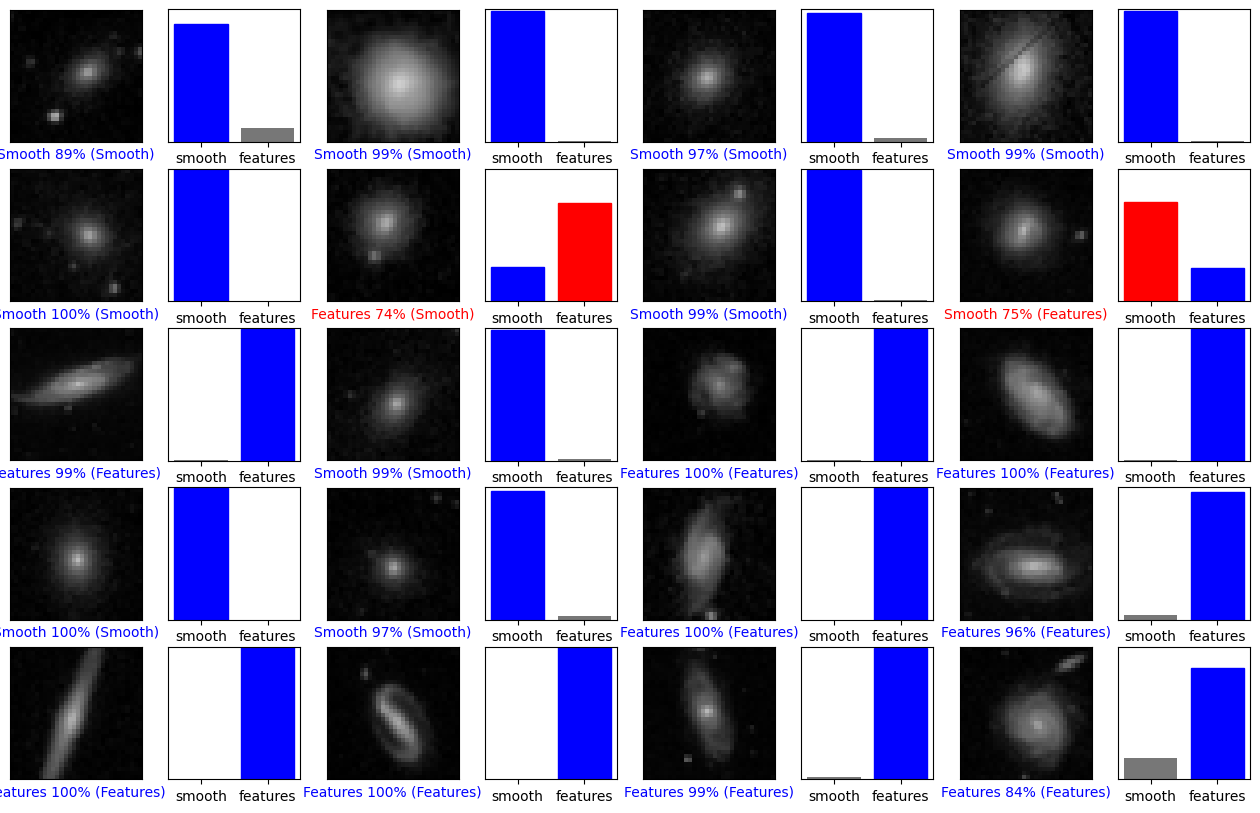

In [63]:
predictions = (model.predict(test_data))

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

In [64]:
# precision and recall
from sklearn.metrics import precision_score, recall_score

print("Precision:",precision_score(np.int_(test_label),np.argmax(predictions,axis=1)))
print("Recall:",recall_score(np.int_(test_label),np.argmax(predictions,axis=1)))

Precision: 0.9443188241944601
Recall: 0.95049786628734


# Transfer Learning

In [65]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

# Load a pretrained network
# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(target_size, target_size, 3)))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a new classification layer
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x) # 2 classes: smooth, featured

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,650 (56.26 MB)

 Trainable params: 32,962 (128.76 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [66]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist = model.fit(datagen.flow(train_data[:-100], train_label[:-100],
                    batch_size=64),
                    epochs=20,
                    validation_data=(test_data[-100:], test_label[-100:]),
                    )

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.8016 - loss: 0.4712 - val_accuracy: 0.9400 - val_loss: 0.1975
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9130 - loss: 0.2419 - val_accuracy: 0.9500 - val_loss: 0.1546
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9273 - loss: 0.2006 - val_accuracy: 0.9500 - val_loss: 0.1317
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9277 - loss: 0.1902 - val_accuracy: 0.9400 - val_loss: 0.1269
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9325 - loss: 0.1793 - val_accuracy: 0.9600 - val_loss: 0.1213
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9318 - loss: 0.1748 - val_accuracy: 0.9300 - val_loss: 0.1454
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9303 - loss: 0.1750 - val_accuracy: 0.9400 - val_loss: 0.1129
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9458 - loss: 0.1486 - val_acc

# Fine-tuning

In [70]:
base_model.layers

[<InputLayer name=input_layer_1, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <MaxPooling2D name=block1_pool, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <MaxPooling2D name=block3_pool, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <MaxPooling2D name=block4_pool, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>,
 <MaxPooling2D name=block5_pool, built=True>]

In [71]:
# Unfreeze the top layers of the base model
for layer in base_model.layers[-10:]: # unfreeze last 5 layers
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
# Fine-tune the model
hist2 = model.fit(datagen.flow(train_data[:-100], train_label[:-100],
                    batch_size=64),
                    epochs=20,
                    validation_data=(test_data[-100:], test_label[-100:]),
                  )

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9173 - loss: 0.2173 - val_accuracy: 0.9100 - val_loss: 0.1628
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9558 - loss: 0.1171 - val_accuracy: 0.9500 - val_loss: 0.0904
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9646 - loss: 0.0996 - val_accuracy: 0.9500 - val_loss: 0.0916
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9625 - loss: 0.0982 - val_accuracy: 0.9600 - val_loss: 0.0713
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9632 - loss: 0.0947 - val_accuracy: 0.9500 - val_loss: 0.0871
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9659 - loss: 0.0926 - val_accuracy: 0.9900 - val_loss: 0.0545
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9704 - loss: 0.0806 - val_accuracy: 0.9700 - val_loss: 0.0714
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9706 - loss: 0.0835 - val_acc

Text(0.5, 0, 'Epoch')

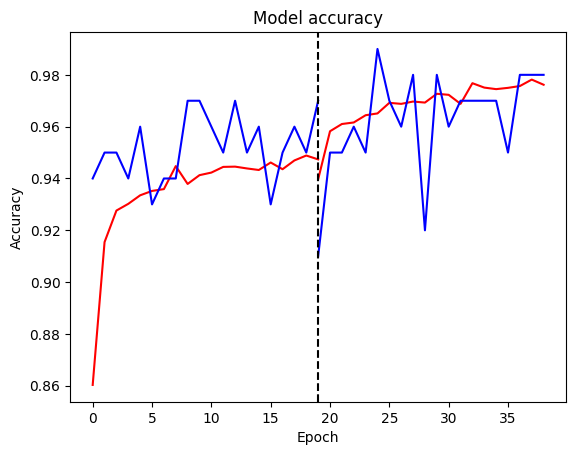

In [73]:
plt.plot(hist.history['accuracy'],'r-')
plt.plot(hist.history['val_accuracy'],'b-')
plt.plot(np.arange(19,39),hist2.history['accuracy'],'r-')
plt.plot(np.arange(19,39),hist2.history['val_accuracy'],'b-')

plt.axvline(x=19,color='k',linestyle='--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


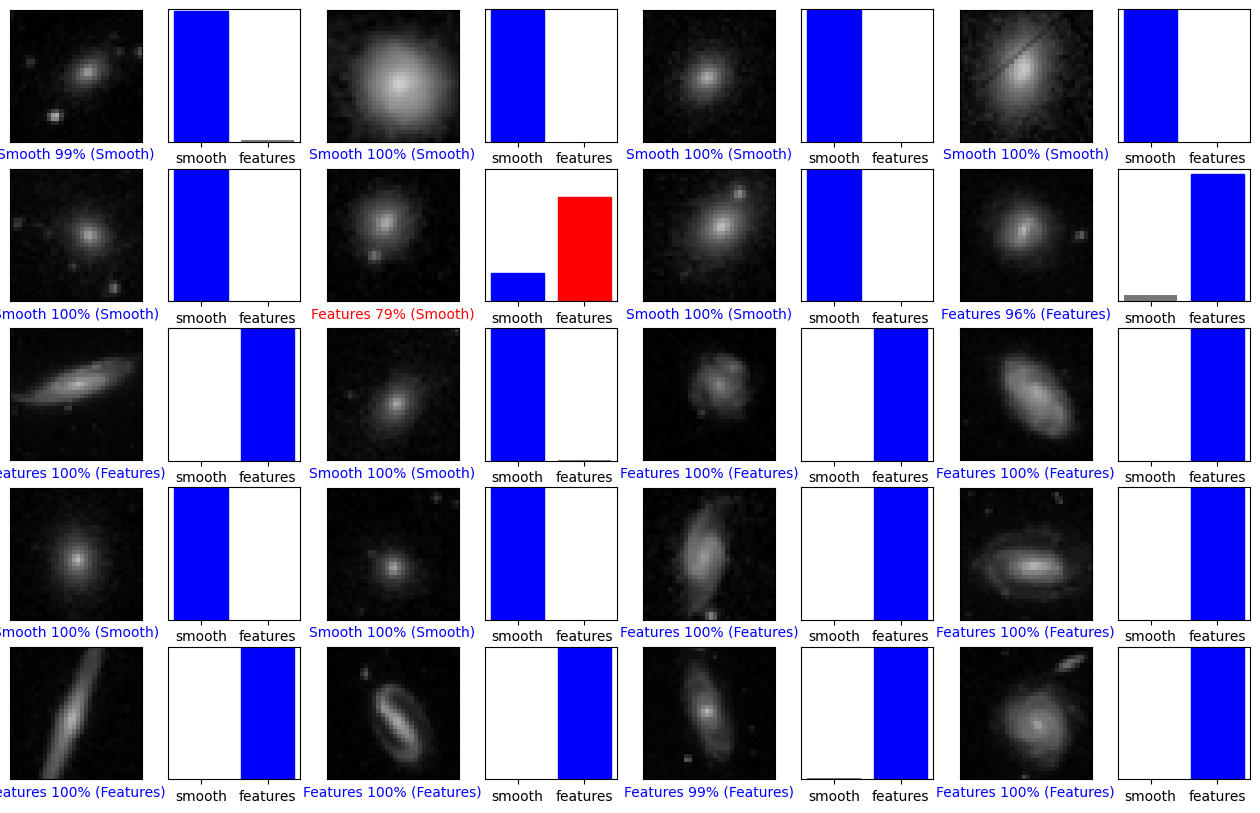

In [74]:
predictions = (model.predict(test_data))

num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, np.int_(test_label), test_data)
  f=plt.subplot(num_rows, 2*num_cols, 2*i+2)
  f.axes.set_xticklabels(["smooth","features"])
  plot_value_array(i, predictions, np.int_(test_label))
plt.show()

In [75]:
test_loss, test_acc = model.evaluate(test_data, test_label)
print('Test accuracy:', test_acc)

212/212 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9711 - loss: 0.0739
Test accuracy: 0.9723126888275146


In [76]:
# calculate precision and recall
print("Precision:",precision_score(np.int_(test_label),np.argmax(predictions,axis=1)))
print("Recall:",recall_score(np.int_(test_label),np.argmax(predictions,axis=1)))

Precision: 0.9551422319474836
Recall: 0.993456614509246
